## Problem 1

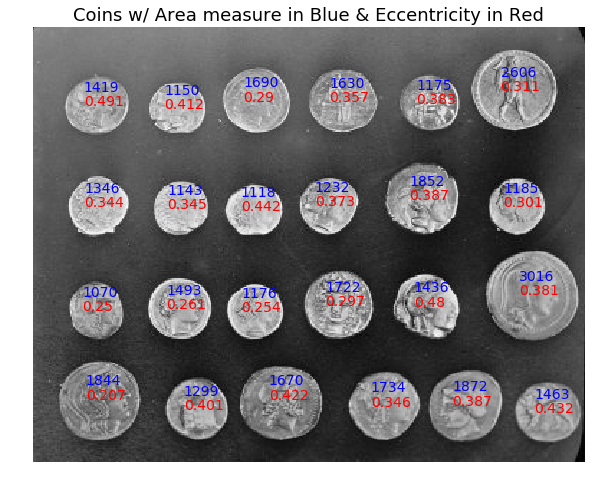

In [234]:
#Run this cell to see figure with results of the "Counting Objects" Problem

#import needed modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage.morphology import closing, opening, square, skeletonize
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage import data, exposure, img_as_float
from skimage.measure import regionprops, label
from skimage.color import label2rgb
from scipy import ndimage as ndi

# Open Image as Float 
org_image = img_as_float(data.coins())

# Normalize Image Based on Historgram of Exposure
hist_image = exposure.equalize_hist(org_image, nbins=256, mask=None)

# Apply Binary Otsu Filter
thresh = threshold_otsu(hist_image)
binary = org_image > thresh
binary = ndi.median_filter(binary, size=2) #I may have cheated a little bit here... the coin in the lower left kept trying to fragment on me, so I used this to fill it in


# Remove Features on Edges
bor_image = clear_border(binary)

## Remove Small Objects by Closing, will also fill holes
closed_image = closing(bor_image)

#Measure
image_labels = label(closed_image)
image_rgb= label2rgb(image_labels)
meas_vals = regionprops(image_labels)

#Extract Measures
eccen = []
areas = []
centroid = [] #will use the centroid points for plotting measured vals latter

for region in range(len(meas_vals)):
    if meas_vals[region].area > 10: #removes small objects
        eccen.append(meas_vals[region].eccentricity)
        areas.append(meas_vals[region].area)
        centroid.append(meas_vals[region].centroid)

centroids = np.asarray(centroid) #change type for plotting
eccen = np.around(eccen,3) #round values to fit on image


#Plot Eccentricity and Area Values on Top of Original Coins
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(org_image,cmap='gray')
for i in range(len(eccen)):
    plt.text(centroids[i,1]-10,centroids[i,0], eccen[i],color='red',fontsize='14')
    plt.text(centroids[i,1]-10,centroids[i,0]-10, areas[i],color='blue',fontsize='14')
ax.set_axis_off()
plt.title("Coins w/ Area measure in Blue & Eccentricity in Red",fontsize='18')
plt.show()

## Problem 2 - Stitching
Code and steps addapted from https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb

In [6]:
from __future__ import division, print_function
%matplotlib inline

First things first
Import NumPy and matplotlib, then define a utility function to compare multiple images

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

Load data. The ImageCollection class provides an easy and efficient way to load and represent multiple images. Images in the ImageCollection are not only read from disk when accessed.
Load a series of images into an ImageCollection with a wildcard, as they share similar names.

In [47]:
import skimage.io as io

pano_imgs = io.ImageCollection('/Users/Charlie/Desktop/python-seminar/Homeworks/hw_7/PanoImages/img*')
pano_imgs

Inspect these images using the convenience function compare() defined earlier

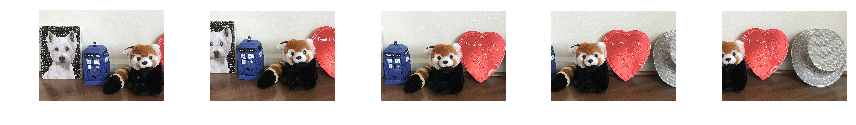

In [48]:
compare(*pano_imgs, figsize=(12, 10))

# 0. Pre-processing
Standardize the images, rotation, ropping, downscaling, grayscale conversion, etc...
Resizing, often downscaling with fixed aspect ratio
Conversion to grayscale, as many feature descriptors are not defined for color images
Cropping to region(s) of interest

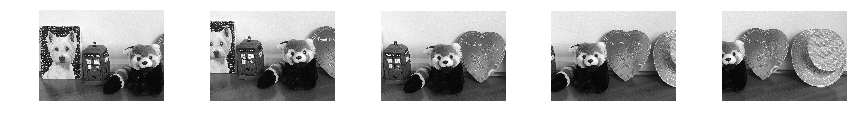

In [49]:
from skimage.color import rgb2gray

pano0, pano1, pano2, pano3, pano4 = [rgb2gray(im) for im in pano_imgs]
# View the results
compare(pano0, pano1, pano2, pano3, pano4, figsize=(12, 10))

# 1. Feature detection and matching
We need to estimate a projective transformation that relates these images together. The steps will be:
1. Define one image as a target or destination image, which will remain anchored while the others are warped
2. Detect features in all three images
3. Match features from left and right images against the features in the center, anchored image.

In this five-shot series, the middle image pano2 is the logical anchor point.
We detect "Oriented FAST and rotated BRIEF" (ORB) features in both images.

Note: For efficiency, in this tutorial we're finding 800 keypoints. The results are good but small variations are expected. If you need a more robust estimate in practice, run multiple times and pick the best result or generate additional keypoints.

In [123]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Detect keypoints in pano3
orb.detect_and_extract(pano3)
keypoints3 = orb.keypoints
descriptors3 = orb.descriptors

# Detect keypoints in pano4
orb.detect_and_extract(pano4)
keypoints4 = orb.keypoints
descriptors4 = orb.descriptors

Match features to the center image

In [183]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches02 = match_descriptors(descriptors0, descriptors2, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches23 = match_descriptors(descriptors2, descriptors3, cross_check=True)
matches24 = match_descriptors(descriptors2, descriptors4, cross_check=True)

Inspect these matched features side-by-side using the convenience function skimage.feature.plot_matches.

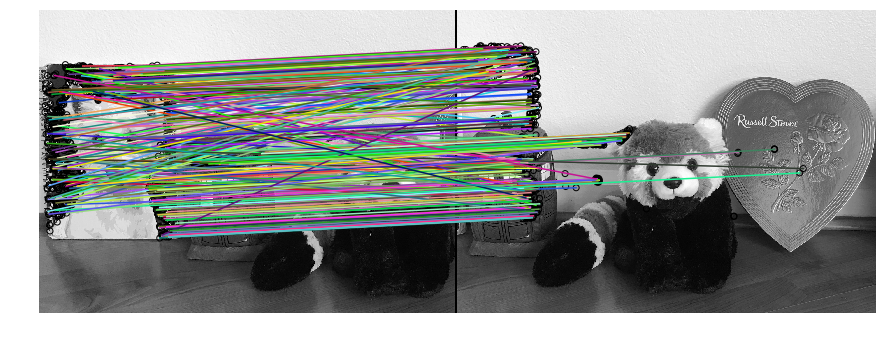

In [184]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano2, keypoints0, keypoints1, matches01)
ax.axis('off');


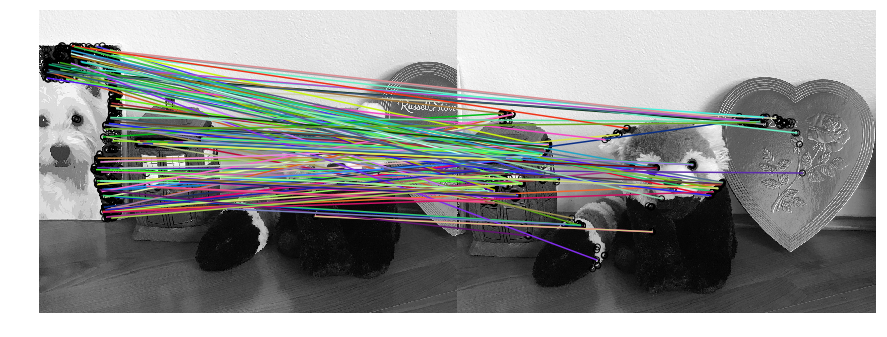

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano1 -> pano2
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12)
ax.axis('off');

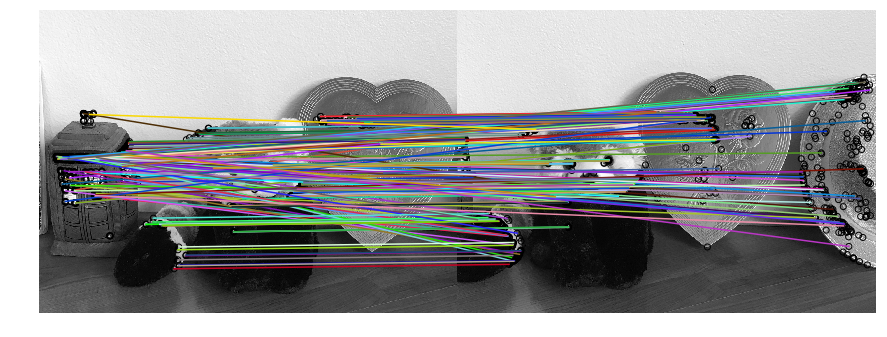

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano1 -> pano2
plot_matches(ax, pano2, pano3, keypoints2, keypoints3, matches23)
ax.axis('off');

# 2. Transform estimation
To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in skimage.transform.ransac. The transformation is estimated iteratively, based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

We need to do this 4 times, once each for the transforms towards the center image
1. far left -> center
2. left -> center 
3. center <- right 
4. center <- far right

Order here matters!

In [188]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

#1) Map far left onto center
#   * source (image to be registered): pano0
#   * target (reference image): pano2, the frame frame registration for left most target
src = keypoints0[matches02[:, 0]][:, ::-1]
dst = keypoints2[matches02[:, 1]][:, ::-1]

model_robust02, inliers02 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

#2) Map inner left to center
#   * source (image to be registered): pano1
#   * target (reference image): pano2, our middle frame registration target
src = keypoints1[matches12[:, 0]][:, ::-1]
dst = keypoints2[matches12[:, 1]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

#3) Map inner right to center
#   * source (image to be registered): pano3
#   * target (reference image): pano2, our middle frame registration target
src = keypoints3[matches23[:, 1]][:, ::-1]
dst = keypoints2[matches23[:, 0]][:, ::-1]

model_robust23, inliers23 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

#4) Map far right onto center
#   * source (image to be registered): pano4
#   * target (reference image): pano3, our middle frame registration target
src = keypoints4[matches24[:, 1]][:, ::-1]
dst = keypoints2[matches24[:, 0]][:, ::-1]

model_robust24, inliers24 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

The inliers returned from RANSAC select the best subset of matches. How do they look?

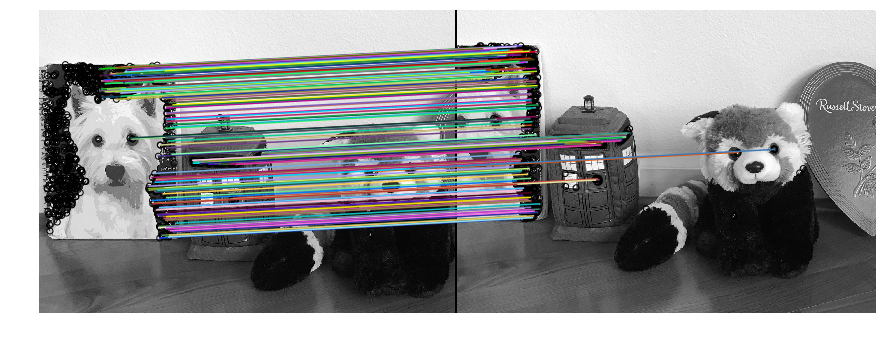

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

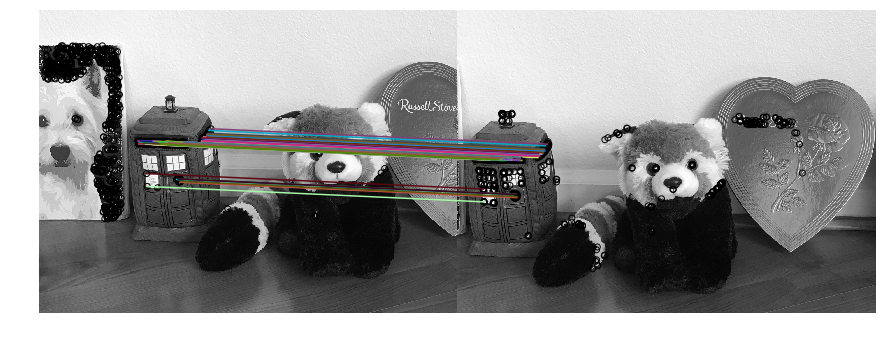

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

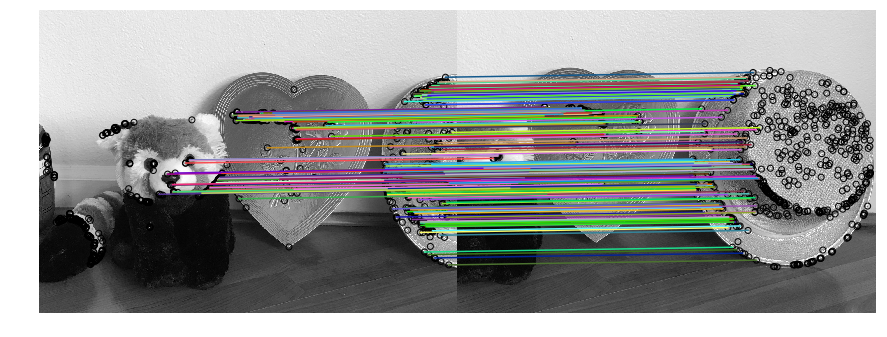

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano3 -> pano4
plot_matches(ax, pano3, pano4, keypoints3, keypoints4, matches34[inliers34])

ax.axis('off');

# 3. Warping
Next, we produce the panorama itself. We must warp, or transform, the outside images so they will properly align with the stationary image.

**Extent of output image**

The first step is to find the shape of the output image to contain all transformed images. To do this we consider the outermost extents of the warped images.

In [263]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano2.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners02 = model_robust02(corners)
warped_corners24 = model_robust24(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack(( warped_corners02, warped_corners24, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)


Apply estimated transforms

Warp the images with skimage.transform.warp according to the estimated models. A shift, or translation is needed to place as our middle image in the middle - it isn't truly stationary.
Values outside the input images are initially set to -1 to distinguish the "background", which is identified for later use.

Note: warp takes the inverse mapping as an input.

In [207]:
from skimage.transform import warp


# This in-plane offset is the only necessary transformation for the middle image
offset2 = SimilarityTransform(translation= -corner_min)

# Translate pano2 into place
pano2_warped = warp(pano2, offset2.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0


Working from inside out, warp left panel into place on center panel

In [208]:
# Warp pano1 (left) to pano2
transform12 = (model_robust12 + offset2).inverse
pano1_warped = warp(pano1, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

Do same, now on left side of center panel

In [209]:
# Warp pano3 (right) to pano2 
transform23 = (model_robust23 + offset2).inverse
pano3_warped = warp(pano3, transform23, order=3,
                    output_shape=output_shape, cval=-1)

pano3_mask = (pano3_warped != -1)  # Mask == 1 inside image
pano3_warped[~pano3_mask] = 0      # Return background values to 0

Let's check to make sure all is going smoothly

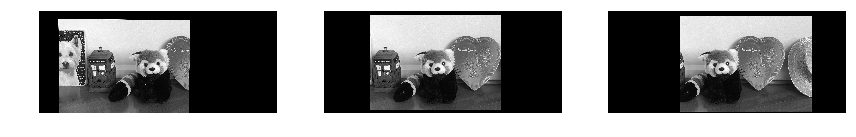

In [236]:
compare(pano1_warped, pano2_warped, pano3_warped, figsize=(12, 10));

Use the left and right panels to transform the the outermost panels now. 
We will need to use a new "in plane" reference for each outside image

In [237]:
# Starting on the far right, map pano0 to pano1
# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)


transform01 = (model_robust01 + offset2).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

In [238]:
# Now the far left, map pano4 to pano3
transform34 = (model_robust34 + offset2).inverse
pano4_warped = warp(pano4, transform34, order=3,
                    output_shape=output_shape, cval=-1)

pano4_mask = (pano4_warped != -1)  # Mask == 1 inside image
pano4_warped[~pano4_mask] = 0      # Return background values to 0

Lets check one more time to see if all 5 are aligned and placed in their relative locations.

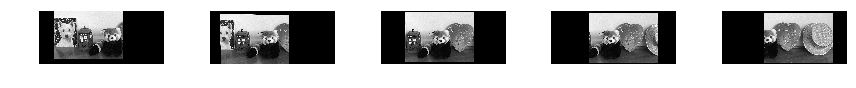

In [239]:
compare(pano0_warped, pano1_warped, pano2_warped, pano3_warped, pano4_warped, figsize=(12, 10));

In [240]:
# Add the images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = ( pano1_warped + pano2_warped + pano3_warped)

In [241]:
# Track the overlap by adding the masks together, only the center 3 are working rn...
overlap = ( # Multiply by 1.0 for bool -> float conversion
           pano1_mask * 1.0 + 
           pano2_mask * 1.0 +
           pano3_mask * 1.0 )

In [251]:
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

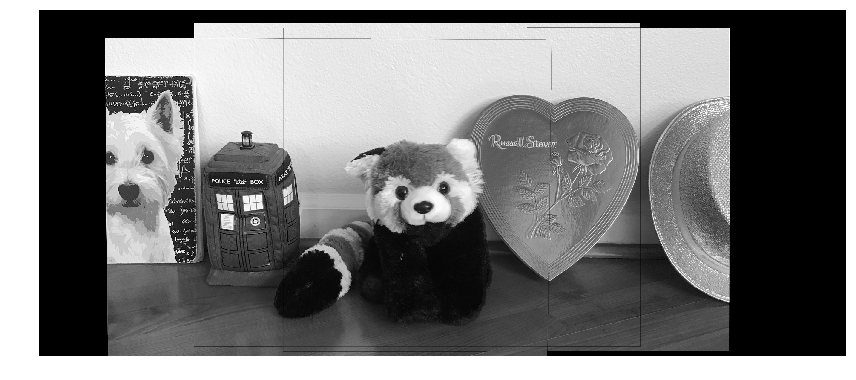

In [252]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

# 4. Merge the Images by Stitching along a minimum-cost path

To accomplish this we need:
1. Starting and ending points for the path
2. A cost array (a modified difference image)

This method is so powerful that, with a carefully constructed cost array, the seed points are essentially irrelevant. It just works!

**Define seed points**

In [253]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

**Construct cost array**

This utility function exists to give a "cost break" for paths from the edge to the overlap region.

In [254]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Use this function to generate the cost array.

In [265]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs02 = generate_costs(np.abs(pano2_warped - pano0_warped),
                         pano2_mask & pano0_mask)

Allow the path to "slide" along top and bottom edges to the optimal horizontal position by setting top and bottom edges to zero cost.

In [266]:
costs02[0,  :] = 0
costs02[-1, :] = 0

Our cost array now looks like this! Kinda Scary

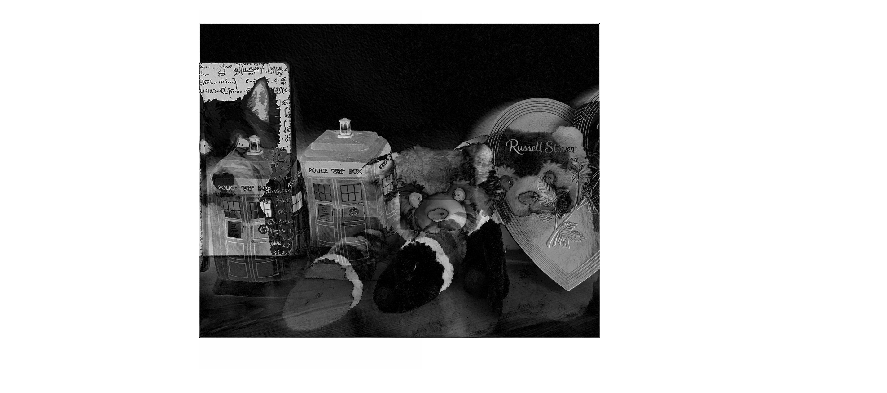

In [268]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs02, cmap='gray', interpolation='none')

ax.axis('off');


**Find the minimum-cost path (MCP)**
Use skimage.graph.route_through_array to find an optimal path through the cost array

In [261]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

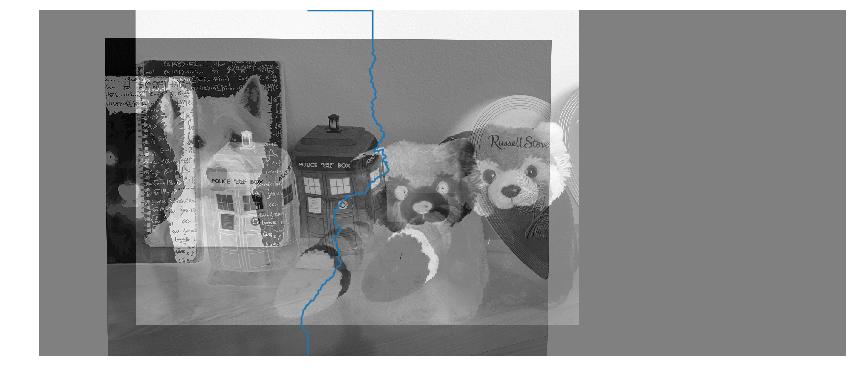

In [262]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');